# NBA Data Extraction & Visualization
#### Eugene Han

## Introduction

This tutorial will introduce some basic methods from scraping data from http://stats.nba.com/ while also focusing on demonstrating methods of visualizing data through [seaborn](http://seaborn.pydata.org/), a "Python visualization library based on matplotlib. It provides a high-level interface for drawing attractive statistical graphics". Our method of scraping will primarily consist of locating the API endpoints instead of extracting the actual data on the webpage. 

### Tutorial Content

We will be utilizing these packages to demonstrate scraping, analyzing, and visualizing NBA data.

[pandas](http://pandas.pydata.org/),
[json](https://docs.python.org/2.7/library/json.html),
[requests](http://docs.python-requests.org/en/master/),
[numpy](http://www.numpy.org/),
[seaborn](http://seaborn.pydata.org/)

We will cover the following topics in this tutorial:
- [Installing seaborn](#Installing-seaborn)
- [Determining how to retrieve the data](#Retrieving-data)
- [Cleaning and formatting team data](#Data-cleaning)
- [Visualizing and analyzing the data](#Data-analysis-and-visualization)

## Instaling seaborn

Before getting started, you will need to install seaborn. We can do so using a quick `pip` install:

    $ pip install --upgrade seaborn

In [12]:
import json
import requests
import pandas as pd
import numpy as np
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt

## Retrieving data

For the first part, we will determine how to scrape the data from [here](http://stats.nba.com/league/team/#!/?Season=2015-16&SeasonType=Regular%20Season&sort=W&dir=1).

If we take a look at the webpage in which we will be scraping for, we observe that there is table for the 2015-2016 NBA season with lots of averages for us to analyze and visualize. 

- Inspect the page
- Head to the Network tab
- Click on the XHR filter and refresh the tab

XHR is short for XMLHttpRequest. This type of request is used to fetch XML or JSON data. If you look closely, we can find the API request that returns the data we are looking for. With most client-side apps these days, our browser does most of the work. Since the browser renders the HTML, we can view where the data comes from.

In [16]:
#The XHR, for those familiar with HTTP you can see the parameters the request has

url = "http://stats.nba.com/stats/leaguedashteamstats?Conference=&DateFrom=&DateTo=&Division=&GameScope=&GameSegment=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerExperience=&PlayerPosition=&PlusMinus=N&Rank=N&Season=2015-16&SeasonSegment=&SeasonType=Regular+Season&ShotClockRange=&StarterBench=&TeamID=0&VsConference=&VsDivision="
response = requests.get(url)

#if we run the below line, we observe that the response we get is json encoded
#print(response.text)

scrape = response.json()

print(scrape["resultSets"][0]['headers']) #the column headers
print #to space out the two print statements
print(scrape["resultSets"][0]['rowSet'][0]) #first team data "Atlanta Hawks"

[u'TEAM_ID', u'TEAM_NAME', u'GP', u'W', u'L', u'W_PCT', u'MIN', u'FGM', u'FGA', u'FG_PCT', u'FG3M', u'FG3A', u'FG3_PCT', u'FTM', u'FTA', u'FT_PCT', u'OREB', u'DREB', u'REB', u'AST', u'TOV', u'STL', u'BLK', u'BLKA', u'PF', u'PFD', u'PTS', u'PLUS_MINUS', u'CFID', u'CFPARAMS']

[1610612737, u'Atlanta Hawks', 82, 48, 34, 0.585, 48.4, 38.6, 84.4, 0.458, 9.9, 28.4, 0.35, 15.6, 20.0, 0.783, 8.3, 33.8, 42.1, 25.6, 15.0, 9.1, 5.9, 5.0, 19.1, 18.3, 102.8, 3.6, 10, u'Atlanta Hawks']


In [15]:
# Given a season of type int returns the JSON-formatted team data for that given season
# Assumes if Season = 2015, then referring to the 2014-2015 Season
# REQUIRES: Season should be an integer between 1997 and 2017
# ENSURES: returns a dictionary of team statistics for given season

def getTeamData(Season):
    start = Season - 1
    arg = str(start) + "-" + str(Season)[2:]
    url = "http://stats.nba.com/stats/leaguedashteamstats?Conference=&DateFrom=&DateTo=&Division=&GameScope=&GameSegment=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerExperience=&PlayerPosition=&PlusMinus=N&Rank=N&Season=" + arg + "&SeasonSegment=&SeasonType=Regular+Season&ShotClockRange=&StarterBench=&TeamID=0&VsConference=&VsDivision="
    try:
        r = requests.get(url).json()
        return r
    except:
        print(str(Season) + ' failed')
        print(url)
        return None

for i in range(1997, 2017):
    getTeamData(i)

print(getTeamData(2011)["resultSets"][0]['rowSet'][0]) #Atlanta Hawks data from 2010

[1610612737, u'Atlanta Hawks', 82, 44, 38, 0.537, 48.1, 36.2, 78.4, 0.462, 6.1, 17.4, 0.352, 16.4, 21.1, 0.779, 9.3, 30.0, 39.3, 22.0, 13.6, 6.1, 4.2, 4.2, 19.0, 18.5, 95.0, -0.8, 10, u'Atlanta Hawks']


Perhaps we seek more than just a season's team data.

If we traverse to http://stats.nba.com/players/, we see a list of currently active and historic players. If we inspect the page, look at the network tab, turn on the XHR filter and refresh the page, we get the below image.

![alt text](https://i.imgur.com/D3DAkSC.png)

Under 'name' we see the link of the API request. In the preview tab, we can see the response of the API request. Interestingly enough, even when the season parameter is set to 2015-2016 in the API request, we still receive all the IDs of every single basketball player who played post 1995-1996 when the NBA started keeping track of player statistics. I'm not entirely sure why this is, but we will find a way to work around it.

In [38]:
individual_url = "http://stats.nba.com/stats/commonallplayers?IsOnlyCurrentSeason=0&LeagueID=00&Season=2016-17"
individual_ids = requests.get(individual_url).json()
print(individual_ids['resultSets'][0]['headers'])
print
for name in range(10):
    print(individual_ids["resultSets"][0]['rowSet'][name][1])

[u'PERSON_ID', u'DISPLAY_LAST_COMMA_FIRST', u'DISPLAY_FIRST_LAST', u'ROSTERSTATUS', u'FROM_YEAR', u'TO_YEAR', u'PLAYERCODE', u'TEAM_ID', u'TEAM_CITY', u'TEAM_NAME', u'TEAM_ABBREVIATION', u'TEAM_CODE', u'GAMES_PLAYED_FLAG']

Abdelnaby, Alaa
Abdul-Aziz, Zaid
Abdul-Jabbar, Kareem
Abdul-Rauf, Mahmoud
Abdul-Wahad, Tariq
Abdur-Rahim, Shareef
Abernethy, Tom
Able, Forest
Abramovic, John
Abrines, Alex


## Data cleaning

Now that we have learned how to scrape the page, it is time for us to load the data into something more "friendly" for analysis and visualization. We will add the data into a pandas dataframe.

In [18]:
columns = scrape["resultSets"][0]['headers'] 
nba_data = pd.DataFrame(scrape["resultSets"][0]['rowSet'], columns = columns)

#we choose to drop the below columns because they aren't very useful
nba_data = nba_data.drop(["TEAM_ID", "GP", "CFID", "CFPARAMS"], axis = 1)

print(nba_data.head())

           TEAM_NAME   W   L  W_PCT   MIN   FGM   FGA  FG_PCT  FG3M  FG3A  \
0      Atlanta Hawks  48  34  0.585  48.4  38.6  84.4   0.458   9.9  28.4   
1     Boston Celtics  48  34  0.585  48.2  39.2  89.2   0.439   8.7  26.1   
2      Brooklyn Nets  21  61  0.256  48.2  38.2  84.4   0.453   6.5  18.4   
3  Charlotte Hornets  48  34  0.585  48.4  37.0  84.4   0.439  10.6  29.4   
4      Chicago Bulls  42  40  0.512  48.5  38.6  87.4   0.441   7.9  21.4   

      ...       REB   AST   TOV  STL  BLK  BLKA    PF   PFD    PTS  PLUS_MINUS  
0     ...      42.1  25.6  15.0  9.1  5.9   5.0  19.1  18.3  102.8         3.6  
1     ...      44.9  24.2  13.7  9.2  4.2   5.5  21.9  21.0  105.7         3.2  
2     ...      42.4  22.3  14.8  7.6  4.0   5.2  18.0  18.4   98.6        -7.4  
3     ...      43.9  21.7  12.5  7.3  5.3   5.5  18.1  20.4  103.4         2.7  
4     ...      46.3  22.8  13.9  6.0  5.7   5.7  18.8  18.7  101.6        -1.5  

[5 rows x 26 columns]


Once again, perhaps we wish to extract individual player data instead of team data. Below, we look through the list of players and determine which have played for a particular season so we can extract their data for the specific season. Below is how we would theoretically access the data, unfortunately we can't anymore due to the NBA restricting access to certain API endpoints while in the middle of the creation of this notebook.

In [55]:
player_id = None
count = 0

while player_id == None:
    if int(individual_ids["resultSets"][0]['rowSet'][count][5]) >= 2015: #year played until
        player_id = individual_ids["resultSets"][0]['rowSet'][count][0]
    count += 1

# print(player_id)
player_stats_url = "http://stats.nba.com/stats/playerdashboardbygeneralsplits?DateFrom=&DateTo=&GameSegment=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerID=" + str(player_id) + "&PlusMinus=N&Rank=N&Season=2016-17&SeasonSegment=&SeasonType=Pre+Season&ShotClockRange=&VsConference=&VsDivision="
try:
    player_stats_response = requests.get(player_stats_url).json()
    print(player_stats_response['resultSets'][0]['headers'])
    print
    print(player_stats_response['resultSets'][0]['rowSet'])
except:
    print("permission denied")

permission denied


## Data analysis and visualization

For our visualizations we will be using the [seaborn](http://seaborn.pydata.org/api.html) package. I have attached a link to the API reference page.

Suppose we wanted to determine if there is a correlation between the average number of 3-pointers made per game and the number of total wins in a season. We first plot the average number of 3-pointers made per game vs. the number of total wins in a season to make a visual observation.

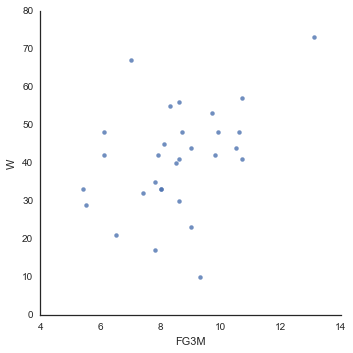

In [64]:
%matplotlib inline
import matplotlib.pyplot as plt

sns.set_style("white") #sets our background white
sns.lmplot(x = "FG3M", y = "W", data=nba_data, fit_reg = False)

Hmm, the above graph seems quite bland and we can't really inference anything. Perhaps, we should try adding more data points to see if we can conclude anything. Using our getTeamData function we built earlier, we will do exactly this. We will also be adding a "YEAR" column to our dataset because the response for the API request to nba.stats does not include the season in the rowSet.

In [19]:
all_seasons = pd.DataFrame(None, columns = columns)

for season in range(1997, 2017):
    data = getTeamData(season)
    if data == None: continue
    temp = pd.DataFrame(data["resultSets"][0]['rowSet'], columns = columns)
    temp['YEAR'] = int(season)
    all_seasons = pd.concat([all_seasons, temp])

all_seasons = all_seasons.sort(['TEAM_NAME', 'YEAR'])
print all_seasons.head()

    AST  BLK  BLKA  CFID       CFPARAMS  DREB  FG3A  FG3M  FG3_PCT   FGA  \
0  19.0  5.2   4.0  10.0  Atlanta Hawks  28.7  22.4   8.0    0.360  76.9   
0  19.1  6.0   4.5  10.0  Atlanta Hawks  29.5  12.4   4.1    0.332  77.5   
0  15.6  5.2   4.9  10.0  Atlanta Hawks  30.0  12.9   3.9    0.306  75.2   
0  18.9  5.6   4.9  10.0  Atlanta Hawks  31.3   9.9   3.1    0.317  83.0   
0  19.0  4.7   6.3  10.0  Atlanta Hawks  30.4  11.4   4.1    0.357  81.3   

    ...    PLUS_MINUS   PTS   REB  STL       TEAM_ID      TEAM_NAME   TOV  \
0   ...           5.4  94.8  41.1  8.5  1.610613e+09  Atlanta Hawks  15.0   
0   ...           3.5  95.9  43.0  7.9  1.610613e+09  Atlanta Hawks  14.8   
0   ...           2.9  86.3  43.5  6.9  1.610613e+09  Atlanta Hawks  14.9   
0   ...          -5.4  94.3  45.3  6.1  1.610613e+09  Atlanta Hawks  15.4   
0   ...          -5.2  91.0  42.9  7.7  1.610613e+09  Atlanta Hawks  16.7   

      W  W_PCT    YEAR  
0  56.0  0.683  1997.0  
0  50.0  0.610  1998.0  
0  31

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


For some unknown reason, the requests call to the NBA API occasionally fails to return a non-empty response. So for this reason, since we have actually been able to successfully grab all the data on this attempt, we will save a copy of this data locally.

In [20]:
all_seasons.to_csv('data.csv')

To retrieve the dataset we saved locally, we can easily get it back via

In [27]:
all_seasons = pd.read_csv('data.csv', index_col = 0)
print(all_seasons.columns)
print(all_seasons.head())

Index([u'AST', u'BLK', u'BLKA', u'CFID', u'CFPARAMS', u'DREB', u'FG3A',
       u'FG3M', u'FG3_PCT', u'FGA', u'FGM', u'FG_PCT', u'FTA', u'FTM',
       u'FT_PCT', u'GP', u'L', u'MIN', u'OREB', u'PF', u'PFD', u'PLUS_MINUS',
       u'PTS', u'REB', u'STL', u'TEAM_ID', u'TEAM_NAME', u'TOV', u'W',
       u'W_PCT', u'YEAR'],
      dtype='object')
    AST  BLK  BLKA  CFID       CFPARAMS  DREB  FG3A  FG3M  FG3_PCT   FGA  \
0  19.0  5.2   4.0  10.0  Atlanta Hawks  28.7  22.4   8.0    0.360  76.9   
0  19.1  6.0   4.5  10.0  Atlanta Hawks  29.5  12.4   4.1    0.332  77.5   
0  15.6  5.2   4.9  10.0  Atlanta Hawks  30.0  12.9   3.9    0.306  75.2   
0  18.9  5.6   4.9  10.0  Atlanta Hawks  31.3   9.9   3.1    0.317  83.0   
0  19.0  4.7   6.3  10.0  Atlanta Hawks  30.4  11.4   4.1    0.357  81.3   

    ...    PLUS_MINUS   PTS   REB  STL       TEAM_ID      TEAM_NAME   TOV  \
0   ...           5.4  94.8  41.1  8.5  1.610613e+09  Atlanta Hawks  15.0   
0   ...           3.5  95.9  43.0  7.9  1.610613

Now we will clean the dataframe by removing the years in which a NBA lockout occurred (i.e. the years in which 82 regular seasons were not played). Then we will remove the columns that are not of importance.

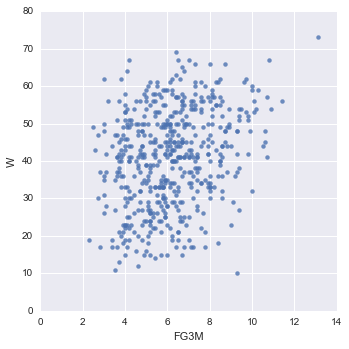

In [121]:
all_seasons = all_seasons[all_seasons['GP'] == 82]
all_seasons = all_seasons.drop(["TEAM_ID", "GP", "CFID", "CFPARAMS"], axis = 1)

sns.set(color_codes=True)
sns.lmplot(x="FG3M", y="W", data=all_seasons, fit_reg = False)

Hmm, this graph still seems to not tell us too much other than that wins and average 3-points per made per season have very little correlation. Perhaps we should examine the prominence of the 3-pointer over the years. `lm.plot` is a seaborn function that plots data and a regression model fit. Use the paramater `fit_reg = bool` to include or not include the regression model fit.

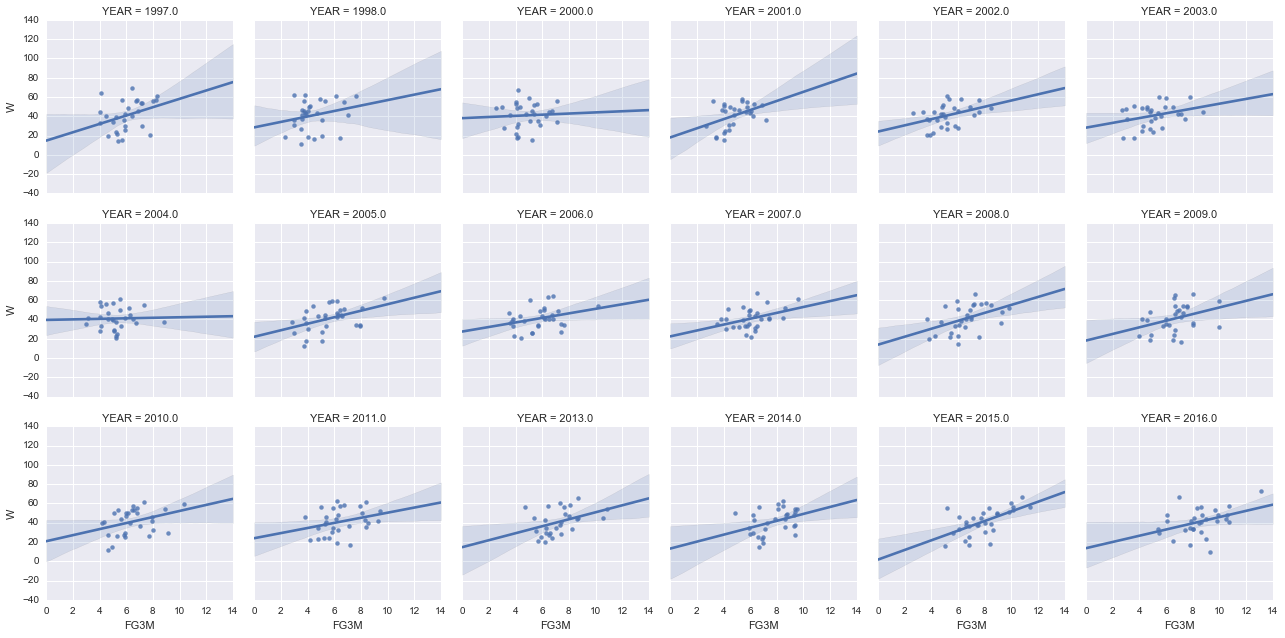

In [122]:
sns.set(color_codes=True)
sns.lmplot(x="FG3M", y="W", col="YEAR", data=all_seasons, fit_reg = True, col_wrap=6, size=3)

From the graphs above, we can visually determine that over the years the 3-point shot has become more correlated with totals wins in a season. Intuitively, any avid watcher of the NBA can tell you that this is indeed true due to the recent emergence of shooters and the emphasis on "big men" being more well-rounded, which includes shooting from the perimeter. We will take a look at one more graph to see if we can find anything interesting. We will be looking at the average of 3-pointers made per season vs the averages wins per season for teams that have played more than 5 seasons. Though typically one would merge the statistics that are essentially the same but under different branding (i.e. Seattle SuperSonics to the Oklahoma City Thunder), we won't be.

           TEAM_NAME          W      FG3M
0      Atlanta Hawks  38.611111  6.111111
1     Boston Celtics  41.176471  6.617647
3  Charlotte Bobcats  31.777778  5.511111
4  Charlotte Hornets  46.428571  5.785714
5      Chicago Bulls  40.888889  5.561111


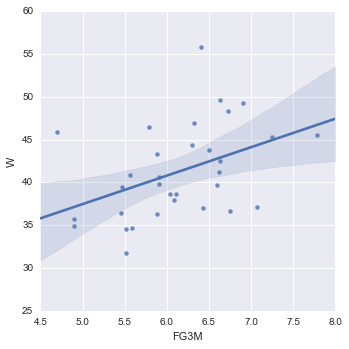

In [159]:
df = all_seasons[['TEAM_NAME', 'W', 'FG3M']]

teams = all_seasons['TEAM_NAME'].unique()

averages = pd.DataFrame(columns = ['TEAM_NAME', 'W', 'FG3M'])

for i, team in enumerate(teams):
    temp_df = all_seasons[all_seasons['TEAM_NAME'] == team]
    if len(temp_df) > 5:
        avg_wins = temp_df['W'].mean()
        avg_FG3M = temp_df['FG3M'].mean()
        averages.loc[i] = [team, avg_wins, avg_FG3M]


print(averages.head())
sns.lmplot(x = "FG3M", y = "W", data=averages, fit_reg = True)
#observe that the graph does not really tell us anything new that we haven't already determined from the other graphs.

Suppose we wish to observe the correlation between average points scored per game and total number of season wins. Normally a scatter plot would suffice. However, for the sake of learning seaborn, we will turn the points into a categorical feature. 

Let x = the mean of average points scored across all seasons with 82 games played and y = the standard deviation. We create a new column labeled 'label' and assign it -1 if the 'PTS' column is less than x-y, 0 if the 'PTS' column is greater than or equal to x-y and less than x+y, 1 otherwise.

In [193]:
mean = all_seasons['PTS'].mean()
std = all_seasons['PTS'].std()

def label(x):
    if x < mean-std:
        return -1
    elif x < mean+std:
        return 0
    else:
        return 1
    
cat_example = all_seasons[['TEAM_NAME', 'W', 'PTS', 'YEAR']]
cat_example['label'] = cat_example['PTS'].apply(label)
cat_example['<2006'] = cat_example['YEAR'].apply(lambda x: 1 if x <= 2005 else 0)
print(cat_example.head())

       TEAM_NAME     W   PTS    YEAR  label  <2006
0  Atlanta Hawks  56.0  94.8  1997.0      0      1
0  Atlanta Hawks  50.0  95.9  1998.0      0      1
0  Atlanta Hawks  28.0  94.3  2000.0      0      1
0  Atlanta Hawks  25.0  91.0  2001.0     -1      1
0  Atlanta Hawks  33.0  94.0  2002.0      0      1


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


A simple way to show the values of some quantitative variable across the levels of a categorical variable is by using `stripplot()`, which generalizes a scatterplot to the case where one of the variables is categorical

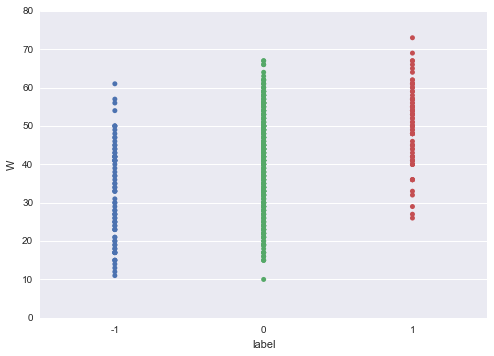

In [189]:
sns.stripplot(x="label", y="W", data=cat_example);

In a strip plot, the scatterplot points will usually overlap. This makes it difficult to see the full distribution of data. One easy solution is to adjust the positions (only along the categorical axis) using some random “jitter”

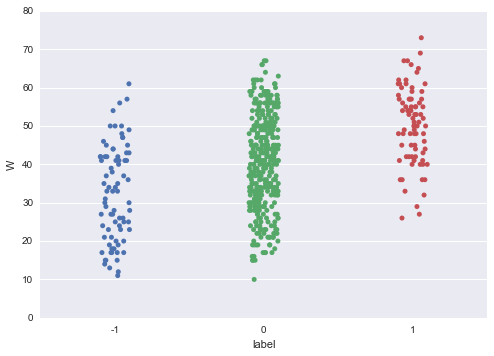

In [187]:
sns.stripplot(x="label", y="W", data=cat_example, jitter=True)

A different approach would be to use the function `swarmplot()`, which positions each scatterplot point on the categorical axis with an algorithm that avoids overlapping points

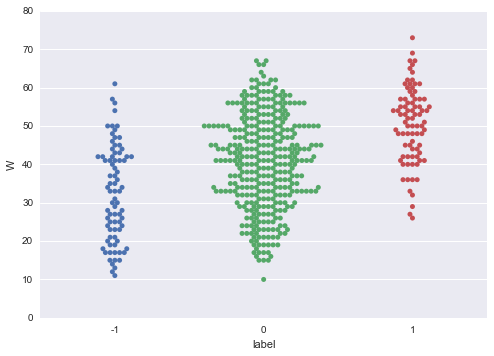

In [186]:
sns.swarmplot(x="label", y="W", data=cat_example);

It’s also possible to add a nested categorical variable with the hue parameter. From the graph below, it is quite clear to see that either the pace of the game has increased over time or teams have become more efficient in scoring.

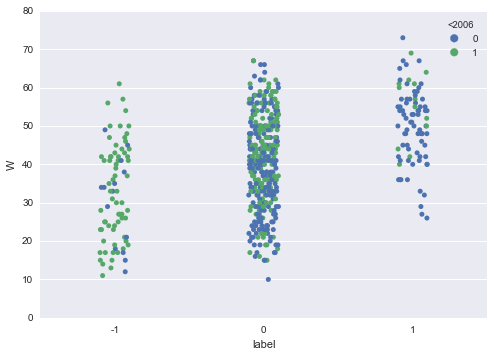

In [194]:
sns.stripplot(x="label", y="W", hue="<2006", data=cat_example, jitter=True);

That concludes this brief tutorial on extracting and visualizing NBA data extraction and visualization.